In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mesh_3d_generator import build_matrix
from svd_compression import compress_matrix, compress
from Tree import Tree, Leaf, InternalNode

In [2]:
from copy import deepcopy

def random_vector(length):
    return np.random.random(length)

def add(node1, node2, max_rank, length):
    if isinstance(node1, Leaf) and node1.zeros:
        return deepcopy(node2)
    elif isinstance(node2, Leaf) and node2.zeros:
        return deepcopy(node1)
    elif isinstance(node1, Leaf) and isinstance(node2, Leaf):
        if node1.U.shape[1] + node2.U.shape[1] <= max_rank:
            return Leaf(U=np.hstack((node1.U, node2.U)), V=np.vstack((node1.V, node2.V)))
        return compress(node1.U @ node1.V + node2.U @ node2.V, 0, max_rank, length)
    elif isinstance(node1, InternalNode) and isinstance(node2, InternalNode):
        length //= 2
        return InternalNode(
            left_up=add(node1.left_up, node2.left_up, max_rank, length),
            right_up=add(node1.right_up, node2.right_up, max_rank, length),
            left_low=add(node1.left_low, node2.left_low, max_rank, length),
            right_low=add(node1.right_low, node2.right_low, max_rank, length)
        )
    else:
        length //= 2
        if isinstance(node1, InternalNode):
            node1, node2 = node2, node1

        U, V = node1.U, node1.V
        return InternalNode(
            left_up=add(Leaf(U=U[:length], V=V[:, :length]), node2.left_up, max_rank, length),
            right_up=add(Leaf(U=U[:length], V=V[:, length:]), node2.right_up, max_rank, length),
            left_low=add(Leaf(U=U[length:], V=V[:, :length]), node2.left_low, max_rank, length),
            right_low=add(Leaf(U=U[length:], V=V[:, length:]), node2.right_low, max_rank, length)
        )


def mul(node1, node2, max_rank, length):
    if (isinstance(node1, Leaf) and node1.zeros) or (isinstance(node2, Leaf) and node2.zeros):
        return Leaf(zeros=True)
    elif isinstance(node1, Leaf) and isinstance(node2, Leaf):
        return Leaf(U=node1.U @ np.dot(node1.V, node2.U), V=node2.V)

    length //= 2
    if isinstance(node1, Leaf):
        U, V = node1.U, node1.V
        node1.left_up = Leaf(U=U[:length], V=V[:, :length])
        node1.right_up = Leaf(U=U[:length], V=V[:, length:])
        node1.left_low = Leaf(U=U[length:], V=V[:, :length])
        node1.right_low = Leaf(U=U[length:], V=V[:, length:])

    elif isinstance(node2, Leaf):
        U, V = node2.U, node2.V
        node2.left_up = Leaf(U=U[:length], V=V[:, :length])
        node2.right_up = Leaf(U=U[:length], V=V[:, length:])
        node2.left_low = Leaf(U=U[length:], V=V[:, :length])
        node2.right_low = Leaf(U=U[length:], V=V[:, length:])

    return InternalNode(
        left_up=add(mul(node1.left_up, node2.left_up, max_rank, length),
                    mul(node1.right_up, node2.left_low, max_rank, length), max_rank, length),
        right_up=add(mul(node1.left_up, node2.right_up, max_rank, length),
                    mul(node1.right_up, node2.right_low, max_rank, length), max_rank, length),
        left_low=add(mul(node1.left_low, node2.left_up, max_rank, length),
                    mul(node1.right_low, node2.left_low, max_rank, length), max_rank, length),
        right_low=add(mul(node1.left_low, node2.right_up, max_rank, length),
                    mul(node1.right_low, node2.right_low, max_rank, length), max_rank, length)
    )



def add_matrices(h_mat1, h_mat2):
    if h_mat1.length != h_mat2.length:
        raise ValueError("Matrices should have the same dimensions in order to add them")
    max_rank = min(h_mat1.max_rank, h_mat2.max_rank)
    root = add(h_mat1.root, h_mat2.root, max_rank, h_mat1.length)
    return Tree(h_mat1.length, max_rank, root)

def multiply_matrices(h_mat1, h_mat2):
    if h_mat1.length != h_mat2.length:
        raise ValueError("Matrices should have the same dimensions in order to multiply them")
    max_rank = min(h_mat1.max_rank, h_mat2.max_rank)
    root = mul(h_mat1.root, h_mat2.root, max_rank, h_mat1.length)
    return Tree(h_mat1.length, max_rank, root)


In [19]:
k_val = [2, 3, 4]

In [20]:
mat1 = list(map(build_matrix, k_val))

In [21]:
compressed1 = list(map(lambda mat: compress_matrix(mat, 0, 10), mat1))

In [22]:
def draw_matrices(matrix_list):
    n = len(matrix_list)
    fig, axes = plt.subplots(1, n)
    for mat, ax in zip(matrix_list, axes):
        ax.imshow(mat.draw(), cmap='gray')
        ax.axis('off')

    plt.subplots_adjust(
        left=0.0,
        bottom=0.0,
        right=1,
        top=1,
        wspace=0.25,
        hspace=0.25
    )
    plt.show()

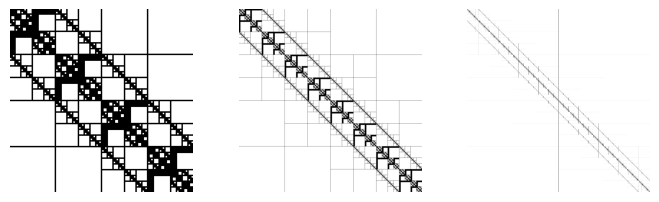

In [23]:
draw_matrices(compressed1)

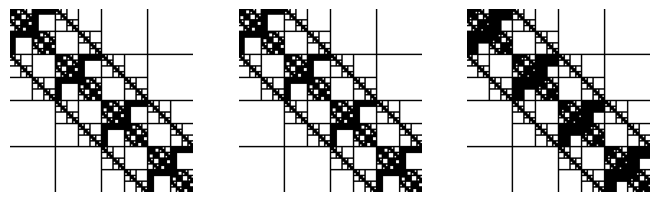

In [24]:
mat_sum = add_matrices(compressed1[0], deepcopy(compressed1[0]))
draw_matrices([compressed1[0], deepcopy(compressed1[0]), mat_sum])

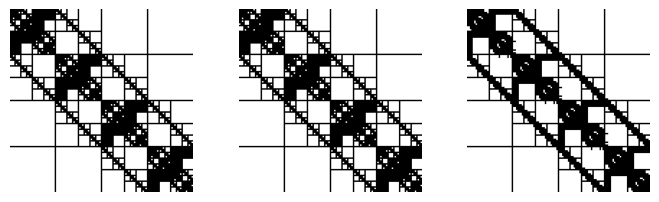

In [26]:
mat_sum2 = add_matrices(mat_sum, deepcopy(mat_sum))
draw_matrices([mat_sum, mat_sum, mat_sum2])

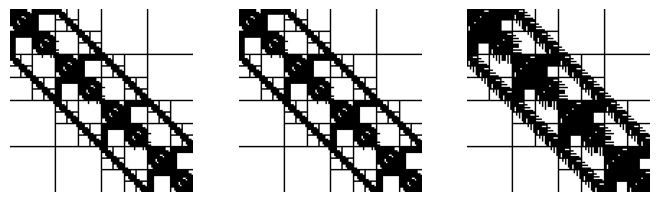

In [27]:
mat_sum3 = add_matrices(mat_sum2, deepcopy(mat_sum2))
draw_matrices([mat_sum2, mat_sum2, mat_sum3])

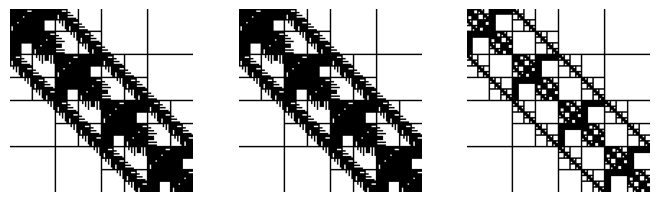

In [28]:
mat_sum4 = add_matrices(mat_sum3, deepcopy(mat_sum3))
draw_matrices([mat_sum3, mat_sum3, mat_sum4])

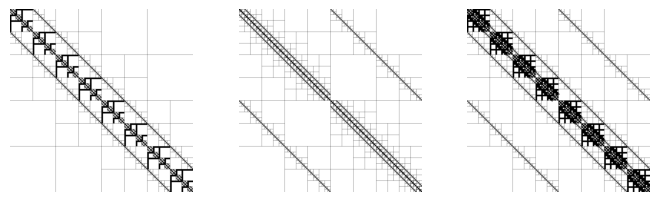

In [31]:
mat_snip = compress_matrix(build_matrix(4)[:512, :512], 0, 10)

draw_matrices([compressed1[1], mat_snip, add_matrices(mat_snip, compressed1[1])])

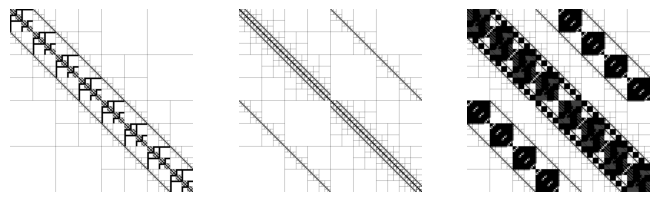

In [32]:
draw_matrices([compressed1[1], mat_snip, multiply_matrices(mat_snip, compressed1[1])])

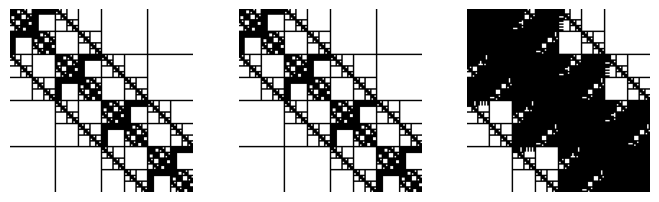

In [33]:
draw_matrices([compressed1[0], deepcopy(compressed1[0]), multiply_matrices(compressed1[0], deepcopy(compressed1[0]))])

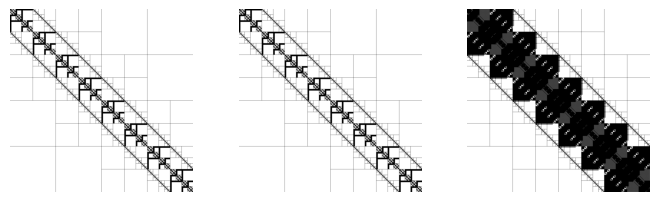

In [34]:
draw_matrices([compressed1[1], deepcopy(compressed1[1]), multiply_matrices(compressed1[1], deepcopy(compressed1[1]))])

In [48]:
def matrix_distance(m1, m2):
    return np.sum(np.square(m1 - m2))

In [45]:
from time import perf_counter

time = []
distance = []
def measure_time(h_matrices, matrices):

    for h_mat, mat in zip(h_matrices, matrices):
        h_mat_copy = deepcopy(h_mat)

        t1 = perf_counter()
        mul_res = multiply_matrices(h_mat, h_mat_copy)
        t2 = perf_counter()

        time.append(t2 - t1)
        distance.append(matrix_distance(mul_res.eval(), mat @ mat))


In [49]:
measure_time(compressed1, mat1)

In [56]:
print(time, distance)

[0.35965980000037234, 0.39784660000441363, 23.88238320000528, 129.69483190000028] [3.250525127142399e-30, 3.250525127142399e-30, 1.0331875314113856e-27, 2.1680390878332185e-28]


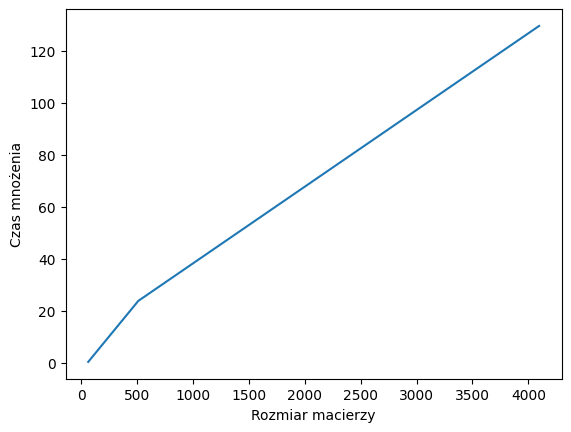

In [53]:
plt.plot([64, 512, 4096], time[1:])
plt.xlabel("Rozmiar macierzy")
plt.ylabel("Czas mnożenia")
plt.show();

In [58]:
from scipy.optimize import curve_fit

def func(x, a, b):
    return a*np.power(x, b)

best_curve, curve_variance = curve_fit(func, [64, 512, 4096], time[1:])
print(best_curve)

[0.12019638 0.83972614]


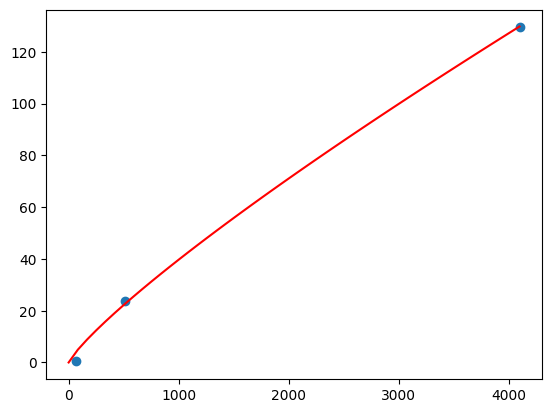

In [60]:
plt.plot([64, 512, 4096], time[1:], linestyle="None", marker="o")
mesh = np.linspace(0, 4096)
mesh_val = func(mesh, best_curve[0], best_curve[1])
plt.plot(mesh, mesh_val, color="red")

In [61]:
from time import perf_counter

time = []
distance = []
def measure_time2(h_matrices, matrices):

    for h_mat, mat in zip(h_matrices, matrices):
        rand_vector = random_vector(h_mat.length)

        t1 = perf_counter()
        res_vector = h_mat.multiply_by_vector(rand_vector)
        t2 = perf_counter()

        time.append(t2 - t1)
        distance.append(matrix_distance(res_vector, mat @ rand_vector))

In [62]:
measure_time2(compressed1, mat1)

In [63]:
print(time, distance)

[0.006728000000293832, 0.04836999999679392, 0.4946607999954722] [1.0230539864584997e-30, 1.1802406847996083e-28, 1.5086425551967422e-28]


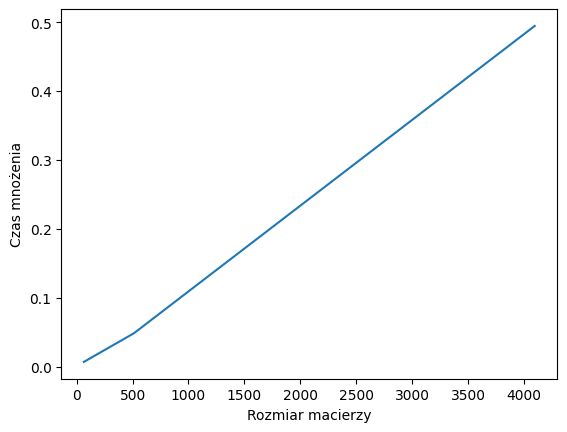

In [66]:
plt.plot([64, 512, 4096], time)
plt.xlabel("Rozmiar macierzy")
plt.ylabel("Czas mnożenia")
plt.show();

In [64]:
best_curve, curve_variance = curve_fit(func, [64, 512, 4096], time)
print(best_curve)

[4.66653918e-05 1.11431204e+00]


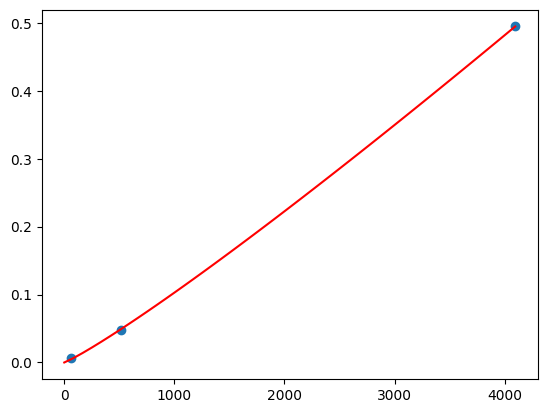

In [65]:
plt.plot([64, 512, 4096], time, linestyle="None", marker="o")
mesh = np.linspace(0, 4096)
mesh_val = func(mesh, best_curve[0], best_curve[1])
plt.plot(mesh, mesh_val, color="red")